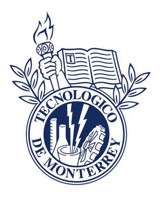

## Instituto Tecnológico y de Estudios Superiores de Monterrey

## Proyecto Integrador

## Dr. Luis Eduardo Falcón Morales

<table text-align="left">
  <tr>
    <th style="text-align:center;">Name</th>
    <th style="text-align:center;">Student ID</th>
  </tr>
  <tr>
    <td style="text-align:left;">Estefania Abigail Castro Belmont</td>
    <td style="text-align:left;">A01332636</td>
  </tr>
  <tr>
    <td style="text-align:left;">Roberto Carlos Avelar Sigüenza</td>
    <td style="text-align:left;">A01016798</td>
  </tr>
  <tr>
    <td style="text-align:left;">Nicolas Mojica Gómez</td>
    <td style="text-align:left;">A01794354</td>
  </tr>
</table>

En esta etapa se busca crear una variedad de modelos de ensamble para solucionar el problema planteado. Para ello, deberán tomar en cuenta las siguientes consideraciones:
Incluir la optimización de hiperparámetros para los modelos más relevantes.
Utilizar algoritmos que apliquen tanto estrategias de ensamble homogéneas como heterogéneas.
Para las estrategias de stacking y/o blending, se deberán emplear los modelos individuales de mejor rendimiento obtenidos en la fase anterior.

Lo primero que hacemos es ajustar para que se utilice el GPU

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        print("Found a GPU with the name:", gpu)
    else:
        print("Failed to detect a GPU.")

In [87]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, BertForTokenClassification, Trainer, TrainingArguments, pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve, auc, roc_curve, auc
import pandas as pd
import time 
import matplotlib.pyplot as plt
import seaborn as sns

## **Tratamiento de datos**

Nos aseguramos de tener los datos correctos, pasarlos a lista y etiquetar las rilas de acuerdo al género al que corresponde cada descripción. Para el género femenino se utilizó el 0 y para el másculino el 1. 
Creamos el conjunto de entrenamiento y prueba con un 80% de entrenamiento y 20% de prueba. A nuestra columna objetivo la renombramos label y aplicamos el random state 42 para que el conjunto no tenga ningún sesgo al estar ordenado por género u alguna otra característica. Después creamos el conjunto en un dataset que se pueda leer en pytorch para que pueda ser manejable para el modelo. 

Todos estos cambios nos permitiran trabajar con los datos de la mejor forma posible.

In [4]:
# Comprobar si hay una GPU disponible y establecer el dispositivo adecuado
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
# Cargar los datos
data = pd.read_excel('descriptivos oracle.xlsx')

In [6]:
# Dividir los datos en características y etiquetas
X = data['Descriptivo'].tolist()
y = data['Género'].tolist()

In [7]:
# Codificar las etiquetas: femenino -> 0, masculino -> 1
labels = [0 if g == 'Femenino' else 1 for g in y]

In [8]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

In [9]:
# Función para crear el conjunto de datos PyTorch
class DescriptivosDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

## **BERT**

El modelo BERT (Bidirectional Encoder Representations from Transformers) es una técnica basada en redes neuronales para el pre-entrenamiento del procesamiento del lenguaje natural (PLN) desarrollada por Google. Es un modelo especializado en lenguaje (LLM, Large Language Model). 

BERT ha sido pre-entrenado con un corpus de 800M de palabras en inglés. BERT tiene corpus que lo han adaptado a español, como lo es el caso del modelo 'dccuchile/bert-base-spanish-wwm-uncased' conocido como BETO y el mismo BERT pero multilingue, modelo 'bert-base-multilingual-cased'. 

Una de las grandes ventajasw de BERT es que puede entrenarce con granularidad al punto en que puede resolver casi cualquier problematica que tenga que ver con el texto que se le dé. Debido a que su entrenamiento es secuencial, va de izquierda a derecha y de derecha a izquierda, BERT es capaz de "comprender" en contexto de las palabras y así inferir lo que cada una de ellas significa (o el peso que tiene en la oración". 

En este caso entrenamos tres modelos de BERT o basados en BERT:
    'dccuchile/bert-base-spanish-wwm-uncased',  # BETO
    'bert-base-multilingual-cased',  # BERT Multilingüe
    'mrm8488/bert-base-spanish-wwm-cased-finetuned-spa-squad2-es'  # Otro modelo en español
    
Debido a que el pre-entrenamiento de BERT nos dio grandes resultados decidimos dejar el modelo en 2 épocas cada uno de los modelos y, al final, realizamos un ensamble de los tres BERTs.

In [10]:
# Función para entrenar un modelo BERT
def train_model(model_name):
    tokenizer = BertTokenizer.from_pretrained(model_name)
    train_encodings = tokenizer(X_train, truncation=True, padding=True, return_tensors='pt')
    test_encodings = tokenizer(X_test, truncation=True, padding=True, return_tensors='pt')

    train_dataset = DescriptivosDataset(train_encodings, torch.tensor(y_train))
    test_dataset = DescriptivosDataset(test_encodings, torch.tensor(y_test))
    
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=2,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset
    )

    start_time = time.time()  # Iniciar tiempo
    trainer.train()
    end_time = time.time()  # Terminar tiempo

    training_time = end_time - start_time  # Calcular tiempo de entrenamiento
    print(f"Modelo {model_name} entrenado en {training_time:.2f} segundos.")
    
    return model, trainer, tokenizer, training_time

In [11]:
# Modelos a utilizar en el ensamble
model_names = [
    'dccuchile/bert-base-spanish-wwm-uncased',  # BETO
    'bert-base-multilingual-cased',  # BERT Multilingüe
    'mrm8488/bert-base-spanish-wwm-cased-finetuned-spa-squad2-es'  # Otro modelo en español
]

In [13]:
# Entrenar múltiples modelos usando un bucle for
models = []
trainers = []
tokenizers = []
training_times = []

for model_name in model_names:
    model, trainer, tokenizer, training_time = train_model(model_name)
    models.append(model)
    trainers.append(trainer)
    tokenizers.append(tokenizer)
    training_times.append(training_time)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/abigail/anaconda3/lib/python3.11/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.661300,0.631437
2,0.402400,0.277018


Modelo dccuchile/bert-base-spanish-wwm-uncased entrenado en 338.98 segundos.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.675500,0.667268
2,0.378600,0.229255


Modelo bert-base-multilingual-cased entrenado en 307.60 segundos.


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at mrm8488/bert-base-spanish-wwm-cased-finetuned-spa-squad2-es and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.685200,0.620611
2,0.386700,0.302828


Modelo mrm8488/bert-base-spanish-wwm-cased-finetuned-spa-squad2-es entrenado en 245.90 segundos.


## **Evaluación**

A continuación vemos las evaluaciones de cada uno de los modelos por separado.
Llama la atención que los dos primeros modelos, BETO y BERT multilingue dan valores de 1, mientras que el último se encuentra en un umbral de 80-89%, con excepción del Recall.

In [67]:
# Evaluar cada modelo individualmente
for model, tokenizer in zip(models, tokenizers):
    test_encodings = tokenizer(X_test, truncation=True, padding=True, return_tensors='pt')
    test_dataset = DescriptivosDataset(test_encodings, torch.tensor(y_test))
    
    trainer = Trainer(model=model)
    predictions = trainer.predict(test_dataset).predictions
    final_predictions = predictions.argmax(axis=1)
    
    accuracy = accuracy_score(y_test, final_predictions)
    precision = precision_score(y_test, final_predictions)
    recall = recall_score(y_test, final_predictions)
    f1 = f1_score(y_test, final_predictions)
    
    print(f"Evaluación del modelo {model.config._name_or_path}:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("\n")

Evaluación del modelo dccuchile/bert-base-spanish-wwm-uncased:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0




Evaluación del modelo bert-base-multilingual-cased:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0




Evaluación del modelo mrm8488/bert-base-spanish-wwm-cased-finetuned-spa-squad2-es:
Accuracy: 0.8833333333333333
Precision: 0.8055555555555556
Recall: 1.0
F1-score: 0.8923076923076924




## **Tiempo de entrenamiento**

Los tiempos de entrenamiento fueron manejables en esta ocasión. Si se aumenta el tamaño del DataSet y se modifica la cantidad de RAM de la que dispone el proyecto, estos podrían variar (quizá bastante). 

In [14]:
# Mostrar tiempos de entrenamiento
for model_name, time_taken in zip(model_names, training_times):
    print(f"Modelo {model_name} fue entrenado en {time_taken:.2f} segundos.")

Modelo dccuchile/bert-base-spanish-wwm-uncased fue entrenado en 338.98 segundos.
Modelo bert-base-multilingual-cased fue entrenado en 307.60 segundos.
Modelo mrm8488/bert-base-spanish-wwm-cased-finetuned-spa-squad2-es fue entrenado en 245.90 segundos.


## **Resultados del ensamble**

Finalmente vemos los resultados de las predicciónes en el modelo ensamblado con los tres BERTs. Los resultados no son malos, ya que se mantienen entre 96%-95%. Recordemos que por el tamaño de los datos (lo que es recomendable, ya que nuestros datos son pocos), podría ser que el modelo esté sobre-entrenado y que al aumentar los mismos los valores cambien. 

In [79]:
def ensemble_predict(models, dataset):
    all_predictions = []
    for model in models:
        trainer = Trainer(model=model)
        predictions = trainer.predict(dataset).predictions
        all_predictions.append(predictions)

    avg_predictions = sum(all_predictions) / len(all_predictions)
    return avg_predictions

# Crear el conjunto de datos de prueba para ensamblar
test_encodings = tokenizers[0](X_test, truncation=True, padding=True, return_tensors='pt')
test_dataset = DescriptivosDataset(test_encodings, torch.tensor(y_test))

ensemble_predictions = ensemble_predict(models, test_dataset)
final_predictions = ensemble_predictions.argmax(axis=1)

# Calcular métricas de evaluación del modelo ensamblado
accuracy = accuracy_score(y_test, final_predictions)
precision = precision_score(y_test, final_predictions)
recall = recall_score(y_test, final_predictions)
f1 = f1_score(y_test, final_predictions)

print("Evaluación del modelo ensamblado sin enmascarar textos:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Evaluación del modelo ensamblado sin enmascarar textos:
Accuracy: 0.9833333333333333
Precision: 1.0
Recall: 0.9655172413793104
F1-score: 0.9824561403508771


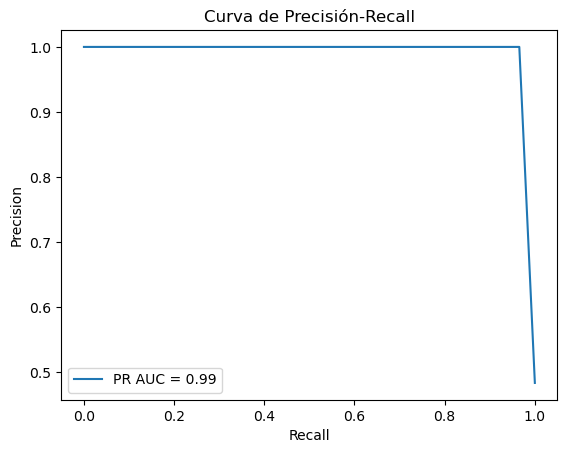

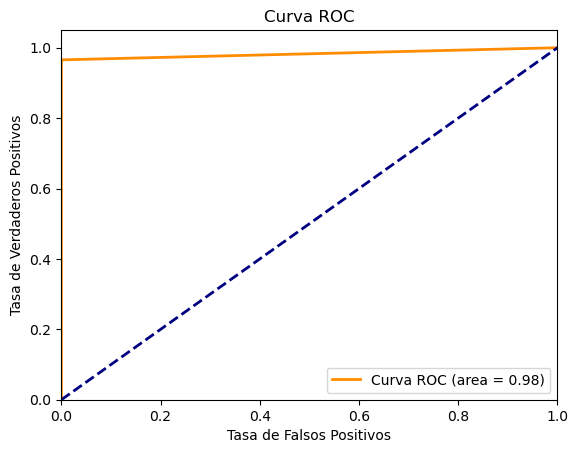

In [89]:
# Curva de Precisión-Recall sin enmascarar
precision_vals, recall_vals, _ = precision_recall_curve(y_test, final_predictions)
auc_pr = auc(recall_vals, precision_vals)

plt.plot(recall_vals, precision_vals, label=f'PR AUC = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva de Precisión-Recall')
plt.legend()
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, final_predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

## **Enmascaramiento usando top words de BERT**

Para realizar el enmascaramiento realizaremos un par de pruebas, ya que hemos obtenido distintos resultados. 
Primeramente intentamos identificar las palabras más importantes dentro del ensamble de bert y estas enmascararlas para que de esta forma no se pudiera conocer el género del candidato en cuestión. Se hicieron pruebas con los pesos de atención y la cantidad de palabras a enmascarar. 
Un punto interesante es que, debido a que nuestros datos fueron generados con modelos, tienen una secuencia de palabras que parece indicar el género desde el inicio. Estas palabras son las que conforman la primer oración de cada descripción. También se hizo un tratamiento de los nombres de las personas y finalmente se imprimieron las descripciones de prueba originales y las enmascaradas, para así tener una breve visualización del funcionamiento del modelo. Dentro de este primer trabajo, podemos ver que hay varias palabras que se incluyen adecuadamente, como los nombres, algunos adjetivos y artículos. Sin embargo, este trabajo no es suficiente para que la descripción sea completamente neutra. 

In [162]:
# Obtener las palabras que revelan el género
def get_gender_words(model, texts, tokenizer):
    model.eval()
    gender_words = []

    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
            outputs = model(**inputs, output_attentions=True)
            attentions = outputs.attentions[-1]  # Última capa de atenciones
            tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
            attention_weights = attentions[0].mean(dim=1).mean(dim=1)  # Promedio de atenciones sobre todas las cabezas y el batch

            # Identificar las palabras con mayor atención
            top_indices = attention_weights.argsort(descending=True)[:20]  # Cambia 5 por el número de palabras que quieres obtener
            top_words = [tokens[idx] for idx in top_indices]
            gender_words.append(top_words)

            # Imprimir las palabras de género identificadas
            print(f"Texto: {text}")
            print(f"Palabras de género: {top_words}\n")

    return gender_words

In [178]:
# Obtener palabras de género para los textos de prueba usando el primer modelo como ejemplo
gender_words_per_text = get_gender_words(models[0], X_test, tokenizers[0])

Texto: María es una desarrolladora web y móvil con un desempeño regular en su trabajo. A pesar de no destacar significativamente en su rendimiento, María demuestra una tenacidad excepcional para enfrentar los desafíos que se le presentan en el día a día. Su perseverancia y dedicación son admirables, ya que siempre busca mejorar sus habilidades y conocimientos técnicos. María es una persona meticulosa y detallista, capaz de seguir las directrices y procedimientos establecidos con precisión. Su actitud proactiva y su disposición para colaborar en equipo la convierten en una colega confiable y solidaria. María posee una creatividad innata que le permite encontrar soluciones innovadoras a problemas complejos, aportando nuevas perspectivas a los proyectos en los que participa. A pesar de no sobresalir en aspectos técnicos específicos, María compensa con su carácter amable y empático, creando un ambiente de trabajo armonioso y cordial. Su capacidad para adaptarse a diferentes situaciones y a

Texto: John es un desarrollador web y móvil con un desempeño estándar. Es un profesional dedicado, con una sólida comprensión de las tecnologías actuales y la capacidad de adaptarse a los cambios en el campo del desarrollo de software. Su habilidad para trabajar en equipo es destacable, ya que es capaz de colaborar de manera efectiva con sus compañeros de trabajo para alcanzar los objetivos del proyecto. John muestra una notable creatividad a la hora de encontrar soluciones a los desafíos técnicos, lo que le permite desarrollar aplicaciones innovadoras y funcionales. Además, su atención al detalle garantiza que los productos que crea sean de alta calidad y cumplan con los estándares de la industria. A pesar de tener un desempeño estándar, John demuestra una notable ética de trabajo y un compromiso con la mejora continua, lo que le permite crecer profesionalmente y seguir aprendiendo nuevas habilidades dentro de su campo. En resumen, John es un desarrollador web y móvil competente y con

Texto: Carlos es un analista de datos con un rendimiento estándar que destaca por su meticulosidad, su capacidad analítica y su enfoque metódico en la resolución de problemas. Posee una habilidad innata para identificar patrones y tendencias en grandes volúmenes de información, lo que le permite extraer conclusiones sólidas y fundamentadas. Es un profesional proactivo, siempre dispuesto a asumir nuevos desafíos y a investigar nuevas herramientas y tecnologías para mejorar su desempeño. Su atención al detalle es encomiable, ya que revisa minuciosamente cada dato y cada análisis para garantizar la precisión y fiabilidad de su trabajo. Carlos es un comunicador efectivo, capaz de transmitir de manera clara y concisa sus hallazgos y recomendaciones tanto a colegas como a directivos, lo que facilita la toma de decisiones informadas en base a su expertise. Su compromiso con la calidad y la excelencia se refleja en su constante búsqueda de la mejora continua, siempre buscando optimizar los pro

Texto: Juan es un ingeniero de sistemas con un desempeño estándar que destaca por su dedicación y perseverancia. Su habilidad para resolver problemas de manera eficiente y efectiva lo convierte en un activo valioso en cualquier equipo de trabajo. Juan posee una mentalidad analítica excepcional que le permite identificar y abordar las necesidades del proyecto de forma precisa y oportuna. Su capacidad para trabajar bajo presión y cumplir con los plazos establecidos demuestran su compromiso con la excelencia en su labor. Juan es un comunicador efectivo, capaz de transmitir información técnica de manera clara y concisa, lo que facilita la colaboración con sus colegas y la toma de decisiones basadas en datos concretos. Su pasión por la tecnología y su sed interminable de conocimiento lo impulsan a mantenerse actualizado en las últimas tendencias y herramientas del campo de la ingeniería de sistemas. La ética de trabajo de Juan es impecable, siempre dispuesto a asumir nuevos desafíos y a apr

Texto: Juan es un ingeniero de sistemas con un desempeño sobresaliente que destaca por su impecable capacidad analítica, su creatividad innata y su asombrosa habilidad para resolver problemas de manera eficiente y efectiva. Su atención meticulosa a los detalles le permite identificar oportunidades de mejora y optimización en los sistemas existentes, aportando soluciones innovadoras que impulsan el crecimiento y la eficacia de cualquier proyecto en el que participa. Juan demuestra un compromiso excepcional con la excelencia en cada tarea que emprende, mostrando una pasión contagiosa por la tecnología y una sed insaciable de conocimiento que lo impulsa a mantenerse actualizado en las últimas tendencias y tecnologías del campo. Su capacidad para trabajar en equipo es encomiable, siendo un líder nato que inspira a sus colegas a alcanzar niveles más altos de rendimiento y colaboración. Juan posee una ética profesional intachable, demostrando una integridad inquebrantable en cada interacción

Texto: Fernando es un analista de datos que se destaca por su falta de precisión en el manejo de los números y su dificultad para identificar patrones significativos en los datos. A menudo, muestra una actitud renuente hacia la actualización de sus habilidades técnicas y tiende a resistirse a aprender nuevas herramientas de análisis de datos. Su enfoque desorganizado en la resolución de problemas dificulta su capacidad para abordar proyectos de manera efectiva y cumplir con los plazos establecidos. Fernando muestra poca iniciativa para proponer soluciones innovadoras y suele quedarse atascado en metodologías obsoletas que limitan su capacidad para adaptarse a entornos de trabajo dinámicos. Su falta de atención al detalle se traduce en informes con errores significativos y conclusiones poco fundamentadas, lo que pone en duda la fiabilidad de su trabajo. Además, su comunicación deficiente con el equipo interno afecta la colaboración y el flujo de información necesarios para el éxito en p

Texto: **Sofía** es una analista de datos con un desempeño estándar que destaca por su meticulosidad, eficiencia y capacidad analítica sobresaliente. Su enfoque detallista y su habilidad para identificar patrones complejos la convierten en una profesional altamente confiable y precisa en su trabajo. Sofía se distingue por su capacidad para gestionar grandes cantidades de información de manera estructurada, facilitando la interpretación de los datos y la generación de insights significativos. Su dedicación y compromiso con los proyectos en los que participa son admirables, siempre buscando alcanzar los objetivos establecidos de manera eficiente y efectiva. Además, su habilidad para trabajar en equipo y comunicar de forma clara y concisa hacen de Sofía una colaboradora colaboradora valiosa en cualquier entorno laboral. Su pasión por la resolución de problemas y su sed constante de aprendizaje la impulsan a estar siempre actualizada con las últimas tendencias y herramientas en el campo de

In [179]:
# Función para obtener nombres usando NER
def get_names_ner(text, nlp_ner):
    entities = nlp_ner(text)
    names = [entity['word'] for entity in entities if entity['entity_group'] == 'PER']
    return names

In [180]:
# Crear el pipeline NER
nlp_ner = pipeline('ner', model='bert-base-multilingual-cased', grouped_entities=True)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/abigail/anaconda3/lib/python3.11/site-packages/transformers/pipelines/token_classification.py:168: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn(


In [181]:
# Función para reemplazar nombres y palabras de género por 'MASK'
def mask_gender_words_and_names(text, gender_words, nlp_ner, tokenizer):
    tokens = tokenizer.tokenize(text)
    masked_tokens = []

    # Obtener nombres usando NER
    names = get_names_ner(text, nlp_ner)

    for token in tokens:
        if token in gender_words or token in names:
            masked_tokens.append('[MASK]')
        else:
            masked_tokens.append(token)

    return tokenizer.convert_tokens_to_string(masked_tokens)

In [182]:
# Reemplazar palabras de género y nombres en los textos de prueba
masked_texts = [mask_gender_words_and_names(text, gender_words, nlp_ner, tokenizers[0]) for text, gender_words in zip(X_test, gender_words_per_text)]

In [183]:
# Imprimir los textos originales y los textos con palabras enmascaradas
for original, masked in zip(X_test, masked_texts):
    print(f"Original: {original}")
    print(f"Enmascarado: {masked}\n")

Original: María es una desarrolladora web y móvil con un desempeño regular en su trabajo. A pesar de no destacar significativamente en su rendimiento, María demuestra una tenacidad excepcional para enfrentar los desafíos que se le presentan en el día a día. Su perseverancia y dedicación son admirables, ya que siempre busca mejorar sus habilidades y conocimientos técnicos. María es una persona meticulosa y detallista, capaz de seguir las directrices y procedimientos establecidos con precisión. Su actitud proactiva y su disposición para colaborar en equipo la convierten en una colega confiable y solidaria. María posee una creatividad innata que le permite encontrar soluciones innovadoras a problemas complejos, aportando nuevas perspectivas a los proyectos en los que participa. A pesar de no sobresalir en aspectos técnicos específicos, María compensa con su carácter amable y empático, creando un ambiente de trabajo armonioso y cordial. Su capacidad para adaptarse a diferentes situaciones 

## **Evaluación de datos enmascarados**
Finalmente hacemos una evaluación del ensamble al intentar predecir las etiquetas con las palabras enmascaradas. Si bien no se tienen buenos resultados en la mayoría de las métricas (siendo la mayor Accuracy: 0.52), el género de los candidatos en los resultados obtenidos con enmascaramiento aún pueden llegar a ser distinguibles para el ojo humano. 

In [184]:
# Evaluar el modelo ensamblado
def ensemble_predict(models, dataset):
    all_predictions = []
    for model in models:
        trainer = Trainer(model=model)
        predictions = trainer.predict(dataset).predictions
        all_predictions.append(predictions)

    avg_predictions = sum(all_predictions) / len(all_predictions)
    return avg_predictions

In [185]:
# Crear el conjunto de datos de prueba para ensamblar
test_encodings = tokenizers[0](masked_texts, truncation=True, padding=True, return_tensors='pt')
test_dataset = DescriptivosDataset(test_encodings, torch.tensor(y_test))

ensemble_predictions = ensemble_predict(models, test_dataset)
final_predictions = ensemble_predictions.argmax(axis=1)

In [186]:
# Calcular métricas de evaluación
accuracy = accuracy_score(y_test, final_predictions)
precision = precision_score(y_test, final_predictions)
recall = recall_score(y_test, final_predictions)
f1 = f1_score(y_test, final_predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.5166666666666667
Precision: 0.0
Recall: 0.0
F1-score: 0.0


/home/abigail/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


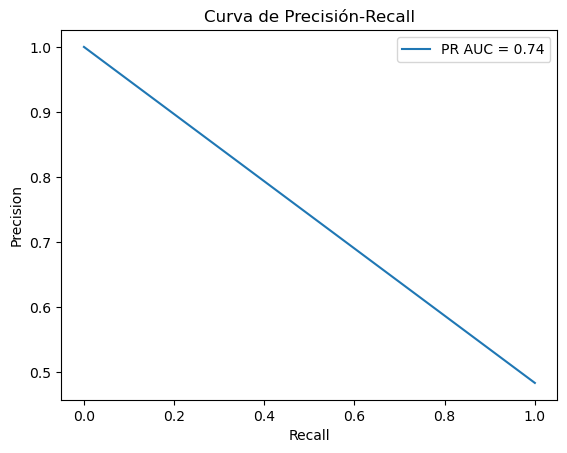

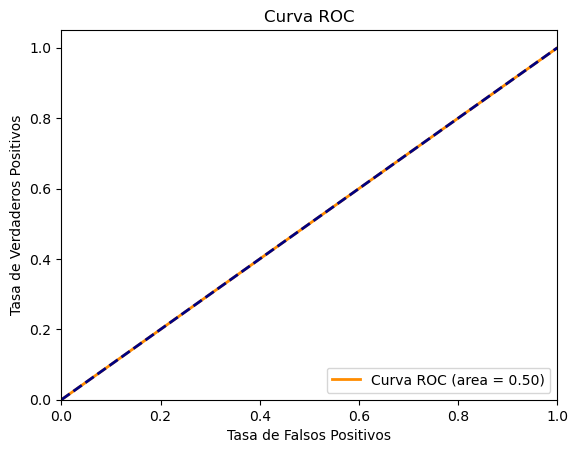

In [187]:
# Curva de Precisión-Recall sin enmascarar
precision_vals, recall_vals, _ = precision_recall_curve(y_test, final_predictions)
auc_pr = auc(recall_vals, precision_vals)

plt.plot(recall_vals, precision_vals, label=f'PR AUC = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva de Precisión-Recall')
plt.legend()
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, final_predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()